In [17]:
import os
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
from shapely.geometry import Point, MultiPolygon
from urllib3.util import Retry
from tenacity import retry, stop_after_attempt, wait_exponential
from shapely.ops import nearest_points
from requests.adapters import HTTPAdapter
from concurrent.futures import ThreadPoolExecutor, as_completed
import folium
import math
import pyproj
from itertools import chain
from pandas.plotting import scatter_matrix 
import seaborn as sns
from sklearn.neighbors import BallTree
from sklearn import set_config
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from dbfread import DBF
from sklearn.preprocessing import LabelEncoder
from functools import reduce
from scipy.stats import skew
from sklearn.feature_selection import RFE, RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score





# ML Pipeline

In [18]:
Features = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/ML Learning Ward Regressions/CSV/Metro.csv')

In [19]:
streetViewParams = [
'NuPhotos',
'PotholeRatio',
'PeopleRatio',
'TrashRatio',
'CarRatio',
'BusRatio',
'TruckRatio',
'MotorbikeRatio',
'RoadRatio', 
'PotholeLagDifference',
'PeopleLagDifference',
'TrashLagDifference',
'CarLagDifference',
'BusLagDifference',
'TrucklagDifference',
'MotorbikeLagDifference',
'RoadLagDifffference',
'PeopleCarRatio']


In [20]:
def plot_distributions(df):
    # Select only numeric features
    numeric_features = df.select_dtypes(include=[np.number])

    # Get number of features
    num_features = len(numeric_features.columns)

    # Dynamically determine number of rows and columns for subplots
    num_cols = 3  # Fixed number of columns
    num_rows = int(np.ceil(num_features / num_cols))  # Adjust rows dynamically

    # Set up figure size dynamically
    plt.figure(figsize=(num_cols * 4, num_rows * 3))  

    # Loop through each numeric feature and create a histogram
    for i, column in enumerate(numeric_features.columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(numeric_features[column], bins=30, kde=True)
        plt.title(column)

    plt.tight_layout()
    plt.show()

# Scalling

In [21]:
ML = Features.copy()

In [22]:
ML = ML[['ANC%', 'DA%', 'EFF%', 'MK%', 'Remaining%'] + streetViewParams]
# Create a new column 'WinningParty' based on the highest percentage vote
parties = ['ANC%', 'DA%', 'EFF%', 'MK%', 'Remaining%']
ML['WinningParty'] = ML[parties].idxmax(axis=1)
ML


,ANC%,DA%,EFF%,MK%,Remaining%,NuPhotos,PotholeRatio,PeopleRatio,TrashRatio,CarRatio,...,PotholeLagDifference,PeopleLagDifference,TrashLagDifference,CarLagDifference,BusLagDifference,TrucklagDifference,MotorbikeLagDifference,RoadLagDifffference,PeopleCarRatio,WinningParty
0,3.641966,84.618423,1.856533,0.260705,9.622373,191,0.047120,0.031414,0.020942,0.696335,...,-0.000009,-0.009770,-0.014789,-0.104132,-0.001829,0.005667,0.004672,-0.004095,0.045113,DA%
1,4.117877,77.315899,3.512881,0.578975,14.474369,174,0.068966,0.057471,0.028736,1.034483,...,-0.229099,-0.002830,0.002748,-0.086981,-0.009701,-0.056638,-0.020257,0.006285,0.055556,DA%
2,2.300659,82.523981,3.214928,0.419664,11.540767,156,0.044872,0.070513,0.012821,0.730769,...,-0.087208,0.055695,-0.027976,-0.030518,0.005389,-0.019835,0.002924,-0.047424,0.096491,DA%
3,21.096912,56.751864,9.510117,2.012780,10.628328,101,0.237624,0.029703,0.108911,0.960396,...,0.136125,-0.006370,0.078839,0.091135,0.017295,0.053807,-0.032520,-0.120318,0.030928,DA%
4,3.160967,83.952861,3.260091,0.583733,9.042348,188,0.053191,0.037234,0.015957,0.765957,...,-0.088861,0.015178,-0.037428,-0.094367,-0.004375,-0.021873,0.006421,0.065638,0.048611,DA%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,57.878315,4.437511,14.629919,0.676027,22.378228,18,0.166667,0.166667,0.055556,0.777778,...,-0.173659,0.110345,-0.114272,0.476724,-0.011494,-0.009100,-0.013889,-0.054662,0.214286,ANC%
1254,73.498833,2.333970,19.117335,1.188203,3.861659,29,0.379310,0.068966,0.034483,0.344828,...,0.109866,-0.019923,-0.142369,-0.100543,0.034483,0.008780,-0.013889,0.126960,0.200000,ANC%
1255,69.113329,3.405755,21.178313,1.076532,5.226072,24,0.291667,0.000000,0.250000,0.208333,...,0.058950,-0.129269,0.169263,-0.209347,-0.018741,0.069000,0.027174,-0.015735,0.200000,ANC%
1256,66.322235,2.889399,21.718331,1.186376,7.883659,46,0.152174,0.152174,0.152174,0.130435,...,-0.158442,0.114693,0.042854,-0.155401,0.010245,-0.021177,0.000604,0.008343,1.166667,ANC%


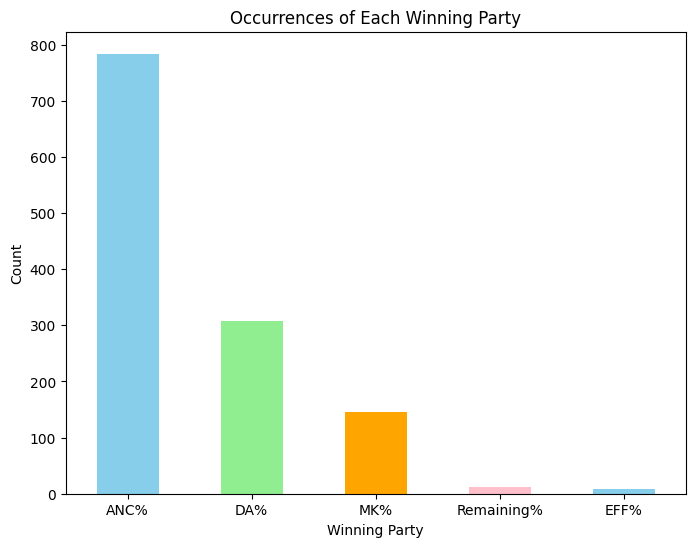

In [23]:
import matplotlib.pyplot as plt

# Plot the occurrences of each value in the 'WinningParty' column
plt.figure(figsize=(8,6))
ML['WinningParty'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'orange', 'pink'])
plt.title('Occurrences of Each Winning Party')
plt.xlabel('Winning Party')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


This shows that i am going to drop if remaining or eff. It will predict three things. 

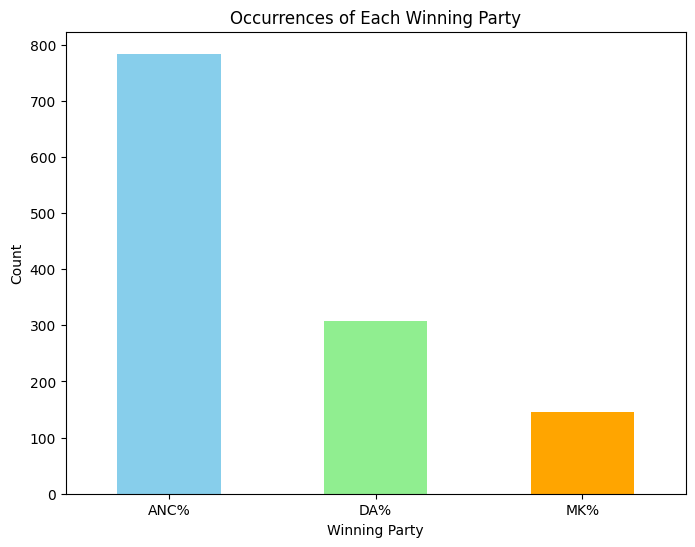

In [24]:
ML = ML[~ML['WinningParty'].isin(['EFF%', 'Remaining%'])]
# Plot the occurrences of each value in the 'WinningParty' column
plt.figure(figsize=(8,6))
ML['WinningParty'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'orange', 'pink'])
plt.title('Occurrences of Each Winning Party')
plt.xlabel('Winning Party')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [25]:
ML = ML.drop(columns=['ANC%', 'DA%', 'EFF%', 'MK%', 'Remaining%'])


# Split the data, stratifying by the target variable (WinningPartyEncoded)
X_train, X_test, y_train, y_test = train_test_split(
    ML.drop(['WinningParty'], axis=1),  # Features (dropping the label)
    ML['WinningParty'],  # Target variable
    test_size=0.2,  # Use 20% of the data as the test set
    random_state=42,  # Ensure reproducibility
    stratify=ML['WinningParty']  # Maintain class distribution in both train and test sets
)

# Check the distribution of the target in the training and test sets
print("Train set target distribution:\n", y_train.value_counts())
print("Test set target distribution:\n", y_test.value_counts())

Train set target distribution:
 WinningParty
ANC%    627
DA%     245
MK%     117
Name: count, dtype: int64
Test set target distribution:
 WinningParty
ANC%    157
DA%      62
MK%      29
Name: count, dtype: int64


In [26]:
# Function to find skewed features that need scaling
def find_features_to_scale(df, skew_threshold=0.5):
    # Identify numeric columns
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    # Calculate skewness for each numeric feature
    skewness = df[numeric_features].apply(lambda x: skew(x.dropna()))

    # Select skewed features
    skewed_features = skewness[abs(skewness) > skew_threshold].index.tolist()
    
    return skewed_features, numeric_features

In [27]:
YeoJohnsonTransformer = PowerTransformer(method='yeo-johnson')

YJ_pipeline = Pipeline([
    ("YJ", YeoJohnsonTransformer),
])

Remainder_pipeline = Pipeline([
    ("Standardize", StandardScaler()),
])


YJ_Attributes, all_numeric_features = find_features_to_scale(X_train)


Remainder_Attributes = list(set(all_numeric_features) - set(YJ_Attributes))


Encoder_Attributes = ['Province']

In [28]:
preprocessing = ColumnTransformer([
    ("Scalling", YJ_pipeline, YJ_Attributes),
    ("Standardise", Remainder_pipeline, Remainder_Attributes),
])

preprocessing

ColumnTransformer(transformers=[('Scalling',
                                 Pipeline(steps=[('YJ', PowerTransformer())]),
                                 ['NuPhotos', 'PotholeRatio', 'PeopleRatio',
                                  'TrashRatio', 'CarRatio', 'BusRatio',
                                  'TruckRatio', 'MotorbikeRatio',
                                  'PotholeLagDifference', 'PeopleLagDifference',
                                  'TrashLagDifference', 'CarLagDifference',
                                  'BusLagDifference', 'TrucklagDifference',
                                  'MotorbikeLagDifference', 'PeopleCarRatio']),
                                ('Standardise',
                                 Pipeline(steps=[('Standardize',
                                                  StandardScaler())]),
                                 ['RoadLagDifffference', 'RoadRatio'])])

In [29]:
processedDataTrain = preprocessing.fit_transform(X_train)
processedDataTest = preprocessing.fit_transform(X_test)



In [30]:
# Convert transformed data back to DataFrame
feature_names = (
    YJ_Attributes +
    Remainder_Attributes 
)


Temp = pd.DataFrame(processedDataTrain, columns=feature_names)
X_train = Temp

Temp = pd.DataFrame(processedDataTest, columns=feature_names)
X_test = Temp

# RandomForest

Accuracy: 0.8225806451612904
Classification Report:
              precision    recall  f1-score   support

        ANC%       0.82      0.96      0.88       157
         DA%       0.84      0.84      0.84        62
         MK%       1.00      0.03      0.07        29

    accuracy                           0.82       248
   macro avg       0.88      0.61      0.60       248
weighted avg       0.84      0.82      0.78       248

Confusion Matrix:


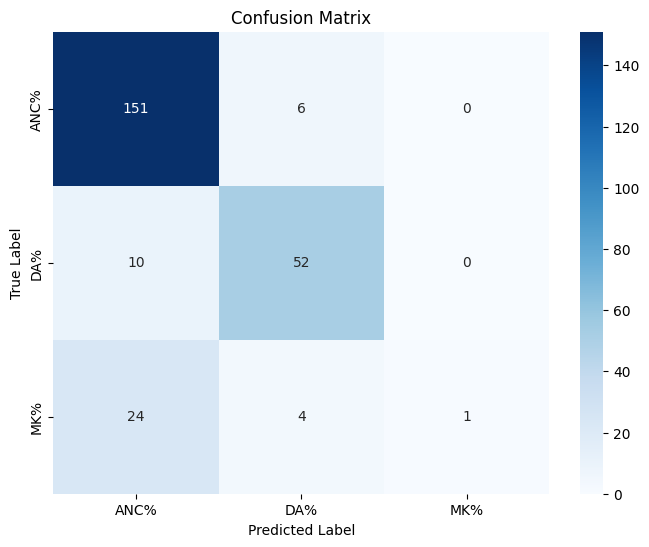

ROC AUC: 0.8771512403921783
Cross-validation scores: [0.82323232 0.83838384 0.81818182 0.81313131 0.80203046]
Average cross-validation score: 0.8189919499564169


In [31]:
# Initialize the classifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Evaluate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC AUC for multiclass (optional, if model supports probabilities)
try:
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    print(f"ROC AUC: {roc_auc}")
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")

# Cross-validation
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Average cross-validation score: {cross_val_scores.mean()}")

# All Models

Training Random Forest...
Accuracy: 0.8225806451612904
Classification Report:
              precision    recall  f1-score   support

        ANC%       0.82      0.96      0.88       157
         DA%       0.84      0.84      0.84        62
         MK%       1.00      0.03      0.07        29

    accuracy                           0.82       248
   macro avg       0.88      0.61      0.60       248
weighted avg       0.84      0.82      0.78       248

Confusion Matrix:


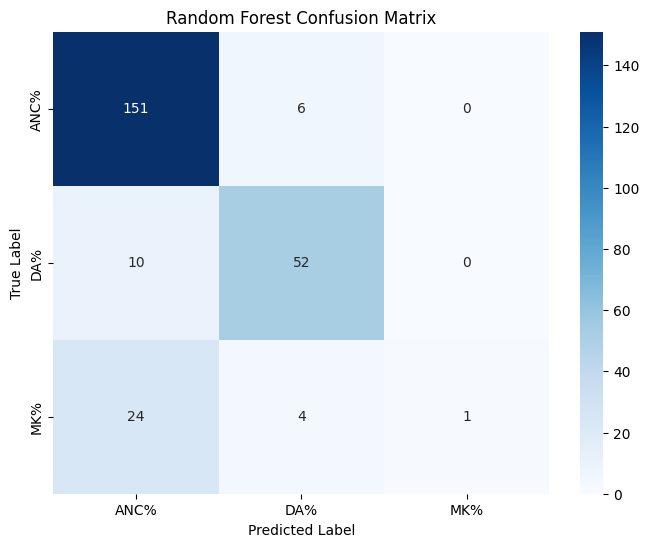

ROC AUC: 0.8771512403921783
Cross-validation scores: [0.82323232 0.83838384 0.81818182 0.81313131 0.80203046]
Average cross-validation score: 0.8189919499564169

------------------------------------------------------------
Training Logistic Regression...
Accuracy: 0.842741935483871
Classification Report:
              precision    recall  f1-score   support

        ANC%       0.83      0.97      0.89       157
         DA%       0.89      0.87      0.88        62
         MK%       0.75      0.10      0.18        29

    accuracy                           0.84       248
   macro avg       0.82      0.65      0.65       248
weighted avg       0.83      0.84      0.81       248

Confusion Matrix:


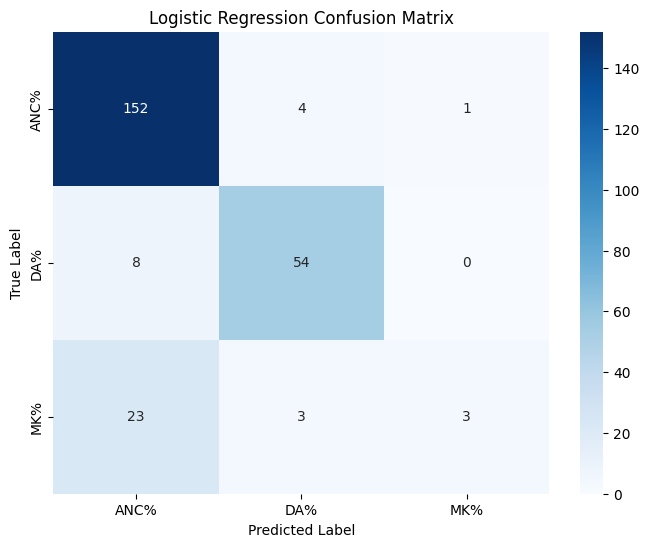

ROC AUC: 0.8570841998112636
Cross-validation scores: [0.81313131 0.83838384 0.82828283 0.81818182 0.81725888]
Average cross-validation score: 0.8230477362457058

------------------------------------------------------------
Training K-Nearest Neighbors...
Accuracy: 0.8064516129032258
Classification Report:
              precision    recall  f1-score   support

        ANC%       0.85      0.90      0.88       157
         DA%       0.76      0.87      0.81        62
         MK%       0.42      0.17      0.24        29

    accuracy                           0.81       248
   macro avg       0.68      0.65      0.64       248
weighted avg       0.78      0.81      0.79       248

Confusion Matrix:


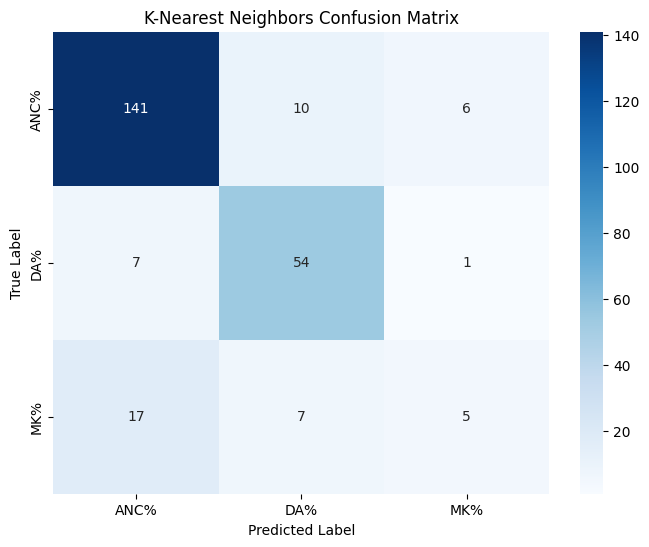

ROC AUC: 0.7998437342597523
Cross-validation scores: [0.75757576 0.8030303  0.79292929 0.77272727 0.7715736 ]
Average cross-validation score: 0.7795672460647081

------------------------------------------------------------
Training Support Vector Classifier...
Accuracy: 0.8306451612903226
Classification Report:
              precision    recall  f1-score   support

        ANC%       0.82      0.97      0.89       157
         DA%       0.85      0.85      0.85        62
         MK%       0.00      0.00      0.00        29

    accuracy                           0.83       248
   macro avg       0.56      0.61      0.58       248
weighted avg       0.73      0.83      0.78       248

Confusion Matrix:


/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

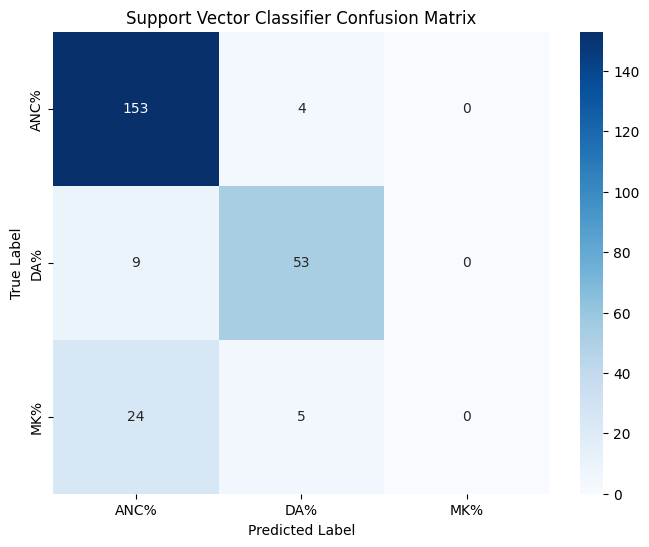

ROC AUC: 0.8522157792164663
Cross-validation scores: [0.83838384 0.83838384 0.82323232 0.80808081 0.82741117]
Average cross-validation score: 0.8270983951186996

------------------------------------------------------------


In [32]:

# Define a list of models to compare
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Classifier', SVC(probability=True, random_state=42))
]

# Loop through models, train, and evaluate them
for model_name, model in models:
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC AUC (if applicable, for multiclass classification)
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
        print(f"ROC AUC: {roc_auc}")
    except ValueError as e:
        print(f"Error calculating ROC AUC: {e}")

    # Cross-validation
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cross_val_scores}")
    print(f"Average cross-validation score: {cross_val_scores.mean()}")
    print("\n" + "-"*60)